# Detailed Secondary Frequency Regulation Study

In this case, we will demonstrate how to use AMS and ANDES to mimic the system secondary frequency regulation, where system automatic generation control (AGC) is used to maintain the system frequency at the nominal value.

Reference:

1. J. Wang et al., "Electric Vehicles Charging Time Constrained Deliverable Provision of Secondary Frequency Regulation," in IEEE Transactions on Smart Grid, doi: [10.1109/TSG.2024.3356948](https://ieeexplore.ieee.org/document/10411057).
1. “Standard BAL-001-2 – Real Power Balancing Control Performance.” [Online]. Available: https://www.nerc.com/pa/Stand/Reliability%20Standards/BAL-001-2.pdf


In [1]:
from itertools import chain

import numpy as np
import scipy
import pandas as pd

import ams
import andes

import matplotlib
import matplotlib.pyplot as plt

Reset matplotlib style to default.

In [2]:
matplotlib.rcdefaults()

Ensure in-line plots.

In [3]:
%matplotlib inline

In [4]:
andes.config_logger(stream_level=40)

In [5]:
ams.config_logger(stream_level=30)

## Dispatch case

We use the IEEE 39-bus system as an example.

In [6]:
sp = ams.load(ams.get_case('ieee39/ieee39_uced.xlsx'),
              setup=True,
              no_output=True,)

In [RTED documentation](https://ltb.readthedocs.io/projects/ams/en/stable/typedoc/DCED.html#id24),
we can see that Var ``rgu`` and ``rgd`` are the variables for RegUp/Dn reserve,
and Constraint ``rbu`` and ``rbd`` are the equality constraints for RegUp/Dn reserve balance.

As for the RegUp/Dn reserve requirements, it is defined by parameter ``du`` and ``dd`` as percentage of the total load,
and later ``dud`` and ``ddd`` are the actual reserve requirements.

In [7]:
sp.RTED.dud.v

array([2.34256, 0.     ])

In [8]:
sp.RTED.du.v

array([0.05, 0.05])

## Dynamic case

In [9]:
sa = sp.to_andes(addfile=andes.get_case('ieee39/ieee39_full.xlsx'),
                 setup=True,
                 no_output=True,
                 default_config=True,
                 )

Generating code for 1 models on 12 processes.


Following PFlow models in addfile will be overwritten: <Bus>, <PQ>, <PV>, <Slack>, <Shunt>, <Line>, <Area>
AMS system 0x3329a7d70 is linked to the ANDES system 0x1060b5910.


Device `ACEc` is used to calculate the Area Control Error (ACE).

In [10]:
sa.ACEc.as_df()

,idx,u,name,bus,bias,busf
uid,,,,,,
0,1,1.0,ACE_1,1,300.0,BusFreq_2


## Synthetic load

ISO-NE provides various grid data, such as [Five-Minute System Demand](https://www.iso-ne.com/isoexpress/web/reports/load-and-demand/-/tree/dmnd-five-minute-sys).
In this example, we revise the March 02, 2024, 18 PM data.

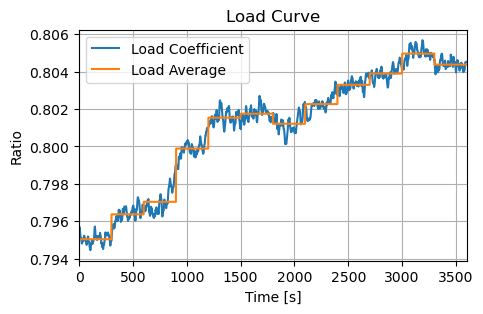

In [11]:
load_isone = np.array([
    11920.071, 11980.979, 12000.579, 12145.243, 12211.862, 12220.703,
    12191.051, 12241.546, 12285.719, 12312.626, 12364.102, 12336.354
])

# Normalize the load
load_min = load_isone.min()
load_max = load_isone.max()
load_mid = (load_max + load_min) / 2  # Midpoint of the range
# Set to desired range
load_range = 0.8 + 0.01 * ((load_isone - load_mid) / (load_max - load_min))

load_scale_base = np.repeat(load_range, 300)
# smooth load_scale_base
load_scale_smooth = scipy.signal.savgol_filter(load_scale_base, 600, 4)

np.random.seed(2024)  # Set random seed for reproducibility
random_bias = np.random.normal(loc=0, scale=0.0015,
                               size=len(load_scale_smooth))
random_smooth = scipy.signal.savgol_filter(random_bias, 20, 1)

# Add noise to the load as random ACE
load_coeff_base = load_scale_smooth + random_smooth
# smooth
load_coeff = scipy.signal.savgol_filter(load_coeff_base, 10, 2)

# NOTE: force the first 2 points to be the same as first interval average
load_coeff[0:2] = load_coeff[0:300].mean()

# average load every N points, for RTED dispatch
load_coeff_avg = load_coeff.reshape(-1, 300).mean(axis=1)
load_coeff_avg = np.repeat(load_coeff_avg, 300)

fig_load, ax_load = plt.subplots(figsize=(5, 3), dpi=100)

ax_load.plot(range(len(load_coeff)), load_coeff,
             label='Load Coefficient')
ax_load.plot(range(len(load_coeff_avg)), load_coeff_avg,
             label='Load Average')

ax_load.set_xlim([0, 3600])
ax_load.set_xlabel('Time [s]')
ax_load.set_ylabel('Ratio')
ax_load.set_title('Load Curve')
ax_load.grid(True)
ax_load.legend()

## Co-simulation

### Define constants

Here we assume the AGC interval is 4 seconds, and RTED interval is 300 seconds.

Between the interoperation of AMS and ANDES, there is a AC conversion step to convert the DC-based dispatch resutls to AC-based power flow results.
For more details, check the reference paper and [AMS source code - dc2ac](https://github.com/CURENT/ams/blob/master/ams/routines/rted.py#L184).

### AGC controller

Since there is not an built-in AGC controller in ANDES, we can define a PI controller to calculate the control signal for the AGC:

AGC_raw = kp * ACE + ki * integral(ACE)

Note that, in the AGC interval, there is a cap operation to limit the AGC signal within procured reserve limits.

### ANDES settings

ANDES load needs to be set to constant load for effective load change.

In [12]:
# --- time constants ---
total_time = 610

RTED_interval = 300
AGC_interval = 4

id_rted = -1  # RTED interval counter
id_agc = -1  # AGC interval counter

# --- AGC controller ---
kp = 0.1
ki = 0.05

ACE_integral = 0
ACE_raw = 0

# --- initialize output ---
# pd_andes: total load in ANDES
# pd_ams: total load in AMS; pg_ams: total generation in AMS
# pru_ams: total RegUp in AMS; prd_ams: total RegDn in AMS
out_cols = ['time', 'freq', 'ACE', 'AGC',
            'pd_andes', 'pd_ams', 'pg_ams',
            'pru_ams', 'prd_ams']
outdf = pd.DataFrame(data=np.zeros((total_time, len(out_cols))),
                     columns=out_cols)

# --- AMS settings ---
sp.SFR.set(src='du', idx=sp.SFR.idx.v, attr='v', value=0.0015*np.ones(sp.SFR.n))
sp.SFR.set(src='dd', idx=sp.SFR.idx.v, attr='v', value=0.0015*np.ones(sp.SFR.n))

# --- ANDES settings ---
sa.TDS.config.no_tqdm = True  # turn off ANDES progress bar
sa.TDS.config.criteria = 0  # turn off ANDES criteria check

# adjsut ANDES TDS settings to save memory
sa.TDS.config.save_every = 0

# adjust dynamic parameters
# NOTE: might run into error if there exists a TurbineGov model that does not have "VMAX"
tbgov_src = [mdl.idx.v for mdl in sa.TurbineGov.models.values()]
tbgov_idx = list(chain.from_iterable(tbgov_src))
sa.TurbineGov.set(src='VMAX', idx=tbgov_idx, attr='v',
                  value=9999 * np.ones(sa.TurbineGov.n),)
sa.TurbineGov.set(src='VMIN', idx=tbgov_idx, attr='v',
                  value=np.zeros(sa.TurbineGov.n),)
syg_src = [mdl.idx.v for mdl in sa.SynGen.models.values()]
syg_idx = list(chain.from_iterable(syg_src))
sa.SynGen.set(src='ra', idx=syg_idx, attr='v',
              value=np.zeros(sa.SynGen.n),)

# use constant power model for PQ
sa.PQ.config.p2p = 1
sa.PQ.config.q2q = 1
sa.PQ.config.p2z = 0
sa.PQ.config.q2z = 0
sa.PQ.pq2z = 0

# save the initial load values
p0_sp = sp.PQ.p0.v.copy()
q0_sp = sp.PQ.q0.v.copy()
p0_sa = sa.PQ.p0.v.copy()
q0_sa = sa.PQ.q0.v.copy()

# --- Co-Sim Variables ---
# save device index
pq_idx = sp.PQ.idx.v  # PQ index

# get a copy of link table to calculate AGC power
# pd.set_option('future.no_silent_downcasting', True)  # pandas setting
maptab = sp.dyn.link.copy().fillna(False)

# existence of each type of generator
maptab['has_gov'] = maptab['gov_idx'].fillna(0, inplace=False).astype(bool).astype(int)
maptab['has_dg'] = maptab['dg_idx'].fillna(0, inplace=False).astype(bool).astype(int)
maptab['has_rg'] = maptab['rg_idx'].fillna(0, inplace=False).astype(bool).astype(int)

# initialize columns for power output
# pg: StaticGen power reference; pru: RegUp power; prd: RegDn power
# pgov: TurbineGov power; prg: RenGen power; pdg: DG power
# bu: RegUp participation factor; bd: RegDown participation factor
# agov: TurbineGov AGC power; adg: DG AGC power; arg: RenGen AGC power

add_cols = ['pg', 'pru', 'prd', 'pgov',
            'prg', 'pdg', 'bu', 'bd',
            'agov', 'adg', 'arg']
maptab[add_cols] = 0

# output data of each unit's AGC power
# aout: delivered AGC power; aref: AGC reference
agc_cols = list(maptab['stg_idx'])
agc_ref = pd.DataFrame(data=np.zeros((total_time, len(list(['time']) + agc_cols))),
                       columns=list(['time']) + agc_cols)
agc_out = pd.DataFrame(data=np.zeros((total_time, len(list(['time']) + agc_cols))),
                       columns=list(['time']) + agc_cols)

# output data of each dispatch interval's results
gen_cols = list(maptab['stg_idx'])
n_dispatch = np.ceil(total_time / RTED_interval).astype(int)
pg_ref = pd.DataFrame(data=np.zeros((n_dispatch, len(list(['n_rted']) + gen_cols))),
                      columns=list(['n_rted']) + gen_cols)
pru_ref = pd.DataFrame(data=np.zeros((n_dispatch, len(list(['n_rted']) + gen_cols))),
                       columns=list(['n_rted']) + gen_cols)
prd_ref = pd.DataFrame(data=np.zeros((n_dispatch, len(list(['n_rted']) + gen_cols))),
                       columns=list(['n_rted']) + gen_cols)

/var/folders/__/n5kx_m_s0tbg6n5qd7rh51700000gn/T/ipykernel_22753/3863718312.py:70: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  maptab = sp.dyn.link.copy().fillna(False)


### Main loop

In [13]:
for t in range(0, total_time, 1):
    # --- Wathdog ---
    if (t % 200 == 0) and (t > 0):
        print(f"--Watchdog: t={t} sec.")

    # --- Dispatch interval ---
    if t % RTED_interval == 0:
        id_rted += 1  # update RTED interval counter
        id_agc = -1   # reset AGC interval counter
        print(f"====== RTED Interval <{id_rted}> ======")
        # use 5-min average load in dispatch solution
        load_avg = load_coeff[t:t+RTED_interval].mean()
        # set load in to AMS
        sp.PQ.set(src='p0', idx=pq_idx, attr='v', value=load_avg * p0_sp)
        sp.PQ.set(src='q0', idx=pq_idx, attr='v', value=load_avg * q0_sp)
        print(f"--AMS: update disaptch load with factor {load_avg:.6f}.")

        # get dynamic generator output from TDS
        if t > 0:
            _receive = sp.dyn.receive(adsys=sa, routine='RTED', no_update=True)
            if _receive:
                print("--AMS: received data from ANDES.")

        # update RTED parameters
        sp.RTED.update()
        # run RTED
        sp.RTED.run(solver='CLARABEL')
        # convert to AC
        flag_2ac = sp.RTED.dc2ac(kloss=1.02 if id_rted == 0 else 1)
        if flag_2ac:
            print(f"--AMS: AC conversion successful.")
        else:
            print(f"ERROR! AC conversion failed!")
            break

        if sp.RTED.exit_code == 0:
            print(f"--AMS: {sp.recent.class_name} optimized.")

            # update in mapping table
            maptab['pg'] = sp.RTED.get(src='pg', attr='v', idx=maptab['stg_idx'])
            maptab['pru'] = sp.RTED.get(src='pru', attr='v', idx=maptab['stg_idx'])
            maptab['prd'] = sp.RTED.get(src='prd', attr='v', idx=maptab['stg_idx'])
            maptab['bu'] = maptab['pru'] / maptab['pru'].sum()
            maptab['bd'] = maptab['prd'] / maptab['prd'].sum()

            # calculate power reference for dynamic generator
            maptab['pgov'] = maptab['pg'] * maptab['has_gov'] * maptab['gammap']
            maptab['pdg'] = maptab['pg'] * maptab['has_dg'] * maptab['gammap']
            maptab['prg'] = maptab['pg'] * maptab['has_rg'] * maptab['gammap']

            # set into governor, Exclude NaN values for governor index
            gov_to_set = {gov: pgov for gov, pgov in zip(maptab['gov_idx'], maptab['pgov']) if bool(gov)}
            sa.TurbineGov.set(src='pref0', idx=list(gov_to_set.keys()), attr='v', value=list(gov_to_set.values()))
            print(f"--ANDES: update TurbineGov reference.")

            # set into dg, Exclude NaN values for dg index
            dg_to_set = {dg: pdg for dg, pdg in zip(maptab['dg_idx'], maptab['pdg']) if bool(dg)}
            sa.DG.set(src='pref0', idx=list(dg_to_set.keys()), attr='v', value=list(dg_to_set.values()))
            print(f"--ANDES: update DG reference.")

            # set into rg, Exclude NaN values for rg index
            rg_to_set = {rg: prg for rg, prg in zip(maptab['rg_idx'], maptab['prg']) if bool(rg)}
            sa.RenGen.set(src='Pref', idx=list(rg_to_set.keys()), attr='v', value=list(rg_to_set.values()))
            print(f"--ANDES: update RenGen reference.")

            # record dispatch data
            pg_ref.loc[id_rted, 'n_rted'] = id_rted
            pg_ref.loc[id_rted, gen_cols] = maptab['pg'].values
            pru_ref.loc[id_rted, 'n_rted'] = id_rted
            pru_ref.loc[id_rted, gen_cols] = maptab['pru'].values
            prd_ref.loc[id_rted, 'n_rted'] = id_rted
            prd_ref.loc[id_rted, gen_cols] = maptab['prd'].values
        else:
            print(f"ERROR! {sp.recent.class_name} failed: {sp.RTED.om.prob.status}")
            break

    # --- AGC interval ---
    if t % AGC_interval == 0:
        id_agc += 1  # update AGC interval counter
        # cap ACE_raw with procured capacity as AGC response
        if ACE_raw >= 0:  # RegUp
            ACE_input = min([ACE_raw, maptab['pru'].sum()])
            b_factor = maptab['bu']
        else:            # RegDn
            ACE_input = -min([-ACE_raw, maptab['prd'].sum()])
            b_factor = maptab['bd']
        outdf.loc[t:t+AGC_interval, 'AGC'] = ACE_input

        maptab['agov'] = ACE_input * b_factor * maptab['has_gov'] * maptab['gammap']
        maptab['adg'] = ACE_input * b_factor * maptab['has_dg'] * maptab['gammap']
        maptab['arg'] = ACE_input * b_factor * maptab['has_rg'] * maptab['gammap']

        # set into governor, Exclude NaN values for governor index
        agov_to_set = {gov: agov for gov, agov in zip(maptab['gov_idx'], maptab['agov']) if bool(gov)}
        sa.TurbineGov.set(src='paux0', idx=list(agov_to_set.keys()), attr='v', value=list(agov_to_set.values()))

        # set into dg, Exclude NaN values for dg index
        adg_to_set = {dg: adg for dg, adg in zip(maptab['dg_idx'], maptab['adg']) if bool(dg)}
        sa.DG.set(src='Pext0', idx=list(adg_to_set.keys()), attr='v', value=list(adg_to_set.values()))

        # set into rg, Exclude NaN values for rg index
        arg_to_set = {rg: arg + prg for rg, arg,
                      prg in zip(maptab['rg_idx'], maptab['arg'], maptab['prg']) if bool(rg)}
        sa.RenGen.set(src='Pref', idx=list(arg_to_set.keys()), attr='v', value=list(arg_to_set.values()))

    # --- TDS interval ---
    if t > 0:  # --- run TDS ---
        # set laod into PQ.Ppf and PQ.Qpf
        sa.PQ.set(src='Ppf', idx=pq_idx, attr='v', value=load_coeff[t] * p0_sa)
        sa.PQ.set(src='Qpf', idx=pq_idx, attr='v', value=load_coeff[t] * q0_sa)
        sa.TDS.config.tf = t
        sa.TDS.run()
        # Update AGC PI controller
        ACE_raw = -(kp * sa.ACEc.ace.v.sum() + ki * ACE_integral)
        ACE_integral = ACE_integral + sa.ACEc.ace.v.sum()

        # record AGC data
        # agc reference
        agc_ref.loc[t, 'time'] = t
        agc_ref.loc[t, agc_cols] = maptab[['agov', 'adg', 'arg']].sum(axis=1).values
        # delivered AGC power
        sp.dyn.receive(adsys=sa, routine='RTED', no_update=True)
        pout = sp.recent.get(src='pg0', attr='v', idx=maptab['stg_idx'])
        pref = sp.recent.get(src='pg', attr='v', idx=maptab['stg_idx'])
        # agc output is the difference between output power and scheduled power
        agc_out.loc[t, 'time'] = t
        agc_out.loc[t, agc_cols] = pout - pref

        # check if to continue
        if sa.exit_code != 0:
            print(f"ERROR! t={t}, TDS error: {sa.exit_code}")
            break
    else:  # --- init TDS ---
        # set pg to StaticGen.p0
        sa.StaticGen.set(src='p0', idx=sp.RTED.pg.get_all_idxes(), attr='v', value=sp.RTED.pg.v)
        # set Bus.v to StaticGen.v
        bus_stg = sp.StaticGen.get(src='bus', attr='v', idx=sp.StaticGen.get_all_idxes())
        v_stg = sp.Bus.get(src='v', attr='v', idx=bus_stg)
        sa.StaticGen.set(src='v0', idx=sp.StaticGen.get_all_idxes(), attr='v', value=v_stg)
        # set vBus to Bus
        sa.Bus.set(src='v0', idx=sp.RTED.vBus.get_all_idxes(), attr='v', value=sp.RTED.vBus.v)
        # set load into PQ.p0 and PQ.q0
        sa.PQ.set(src='p0', idx=pq_idx, attr='v', value=load_coeff[t] * p0_sa)
        sa.PQ.set(src='q0', idx=pq_idx, attr='v', value=load_coeff[t] * q0_sa)
        sa.PFlow.run()  # run power flow
        sa.TDS.init()  # initialize TDS

        if sa.exit_code != 0:
            print(f"ERROR! t={t}, TDS init error: {sa.exit_code}")
            break
        print(f"--ANDES: TDS initialized.")

    # --- record output ---
    outdf.loc[t, 'time'] = t
    outdf.loc[t, 'freq'] = sa.BusFreq.f.v[1]
    outdf.loc[t, 'ACE'] = sa.ACEc.ace.v.sum()
    outdf.loc[t, 'pd_andes'] = sa.PQ.Ppf.v.sum()
    outdf.loc[t, 'pd_ams'] = sp.RTED.pd.v.sum()
    outdf.loc[t, 'pg_ams'] = sp.RTED.pg.v.sum()
    outdf.loc[t, 'pru_ams'] = sp.RTED.pru.v.sum()
    outdf.loc[t, 'prd_ams'] = sp.RTED.prd.v.sum()

# crop the output with valid time
if t < total_time - 1:  # end early, means some error happened
    outdf = outdf[0:t-1]

Building system matrices
<RTED> reinit OModel due to non-parametric change.
Parsing OModel for <RTED>
Evaluating OModel for <RTED>
Finalizing OModel for <RTED>
<RTED> solved as optimal in 0.0127 seconds, converged in 10 iterations with CLARABEL.
Parsing OModel for <ACOPF>
Evaluating OModel for <ACOPF>
Finalizing OModel for <ACOPF>


====== RTED Interval <0> ======
--AMS: update disaptch load with factor 0.795040.


<RTED> converted to AC.


--AMS: AC conversion successful.
--AMS: RTED optimized.
--ANDES: update TurbineGov reference.
--ANDES: update DG reference.
--ANDES: update RenGen reference.
--ANDES: TDS initialized.
--Watchdog: t=200 sec.


Building system matrices
<RTED> reinit OModel due to non-parametric change.
Evaluating OModel for <RTED>
Finalizing OModel for <RTED>
<RTED> solved as optimal in 0.0114 seconds, converged in 10 iterations with CLARABEL.


====== RTED Interval <1> ======
--AMS: update disaptch load with factor 0.796370.
--AMS: received data from ANDES.


<RTED> converted to AC.


--AMS: AC conversion successful.
--AMS: RTED optimized.
--ANDES: update TurbineGov reference.
--ANDES: update DG reference.
--ANDES: update RenGen reference.
--Watchdog: t=400 sec.


Building system matrices
<RTED> reinit OModel due to non-parametric change.
Evaluating OModel for <RTED>
Finalizing OModel for <RTED>
<RTED> solved as optimal in 0.0117 seconds, converged in 10 iterations with CLARABEL.


--Watchdog: t=600 sec.
====== RTED Interval <2> ======
--AMS: update disaptch load with factor 0.797038.
--AMS: received data from ANDES.


<RTED> converted to AC.


--AMS: AC conversion successful.
--AMS: RTED optimized.
--ANDES: update TurbineGov reference.
--ANDES: update DG reference.
--ANDES: update RenGen reference.


## Results

### Data processing

Scale to nominal value

In [14]:
outdf_plt = outdf.copy()
agc_out_plt = agc_out.copy()
agc_ref_plt = agc_ref.copy()

pg_ref_plt = pg_ref.copy()
pru_ref_plt = pru_ref.copy()
prd_ref_plt = prd_ref.copy()

# scale to nominal values
outdf_plt['freq'] *= sa.config.freq
mva_cols = ['pd_andes', 'pd_ams', 'pg_ams',
            'pru_ams', 'prd_ams',
            'ACE', 'AGC']
outdf_plt['prd_ams'] *= -1
outdf_plt[mva_cols] *= sa.config.mva

agc_out_plt[agc_cols] *= sa.config.mva
agc_ref_plt[agc_cols] *= sa.config.mva

pg_ref_plt[gen_cols] *= sa.config.mva
pru_ref_plt[gen_cols] *= sa.config.mva
prd_ref_plt[gen_cols] *= sa.config.mva

# calculate frequency deviation
outdf_plt['fd'] = outdf_plt['freq'] - sa.config.freq

Dispatch results

In [15]:
print('Dispatch generation')
print(pg_ref_plt)

print('Dispatch RegUp')
print(pru_ref_plt)

print('Dispatch RegDn')
print(prd_ref_plt)

Dispatch generation
   n_rted    Slack_39       PV_38       PV_37       PV_36       PV_35  \
0     0.0  386.970702  383.193201  380.621217  380.820996  382.533818   
1     1.0  379.935352  376.269537  373.771156  373.934512  375.594240   
2     2.0  380.257507  376.586537  374.084835  374.249842  375.911982   

        PV_34       PV_33       PV_32       PV_31       PV_30  
0  367.937512  379.728940  385.417787  387.455488  385.588320  
1  361.574196  372.866231  378.381743  380.365045  378.582243  
2  361.865859  373.180473  378.703844  380.689629  378.903045  
Dispatch RegUp
   n_rted  Slack_39     PV_38     PV_37     PV_36     PV_35     PV_34  \
0     0.0  1.287971  0.825139  0.442992  0.267389  0.574634  0.266773   
1     1.0  1.297501  0.836450  0.441245  0.263458  0.576924  0.263087   
2     2.0  1.295520  0.837502  0.441919  0.264108  0.577644  0.263742   

      PV_33     PV_32     PV_31     PV_30  
0  0.267681  0.442814  0.513461  0.698435  
1  0.263505  0.441893  0.513794  0.

AGC mileage in MWh

In [16]:
agc_row_index = np.arange(0, total_time, AGC_interval)
agc_mileage = agc_out_plt.loc[agc_row_index, agc_cols].diff().abs().sum(axis=0) * AGC_interval / 3600

print(f"AGC milage in MWh:\n{agc_mileage}")

AGC milage in MWh:
Slack_39    0.192374
PV_38       0.018822
PV_37       0.014038
PV_36       0.013970
PV_35       0.014016
PV_34       0.012151
PV_33       0.015037
PV_32       0.013776
PV_31       0.014142
PV_30       0.014817
dtype: float64


CPS1 score

Following adjustments are made to calculate the CPS1 score:
1. eps is the constant derived from a targeted frequency bound, where we use the average frequency deviation as the reference
1. The $CF_{clock-minute}$ is used when calcualting $CF$ rather than $CF_{12-month}$

In [17]:
def cm_avg(x):
    """
    Clock minute average

    Parameters
    ----------
    x : pd.Series
        Input time series, index is time in seconds.

    Returns
    -------
    float
        Clock minute average of the time series.
    """
    return np.sum(x) / len(x)

eps = outdf_plt['fd'].mean()
bias = sa.ACEc.bias.v[0]

df_cm = cm_avg(outdf_plt['fd'])
ace_cm = cm_avg(outdf_plt['ACE'] / (10 * bias))
cf_cm = df_cm * ace_cm 
cf = cf_cm / np.square(eps)
cps1 = (2 - cf) * 100

print(f"CPS1 score: {cps1}")

CPS1 score: 100.00360717514486


### Plot

System dynamics

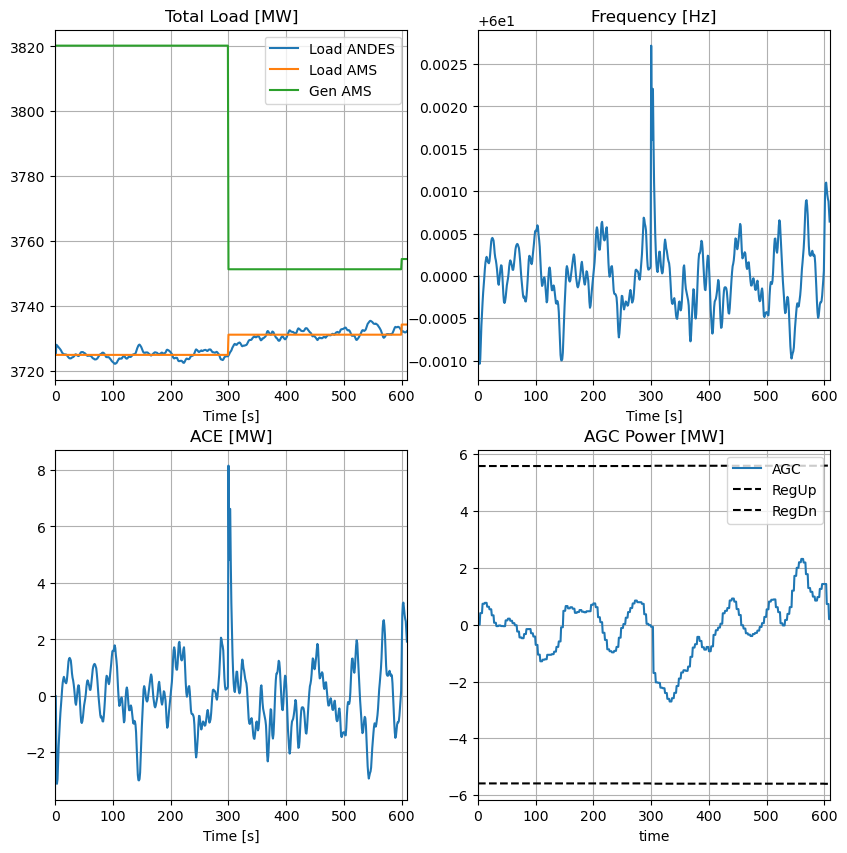

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=100)

outdf_plt.plot(x='time', y='pd_andes', ax=ax[0, 0],
               title='Total Load [MW]',
               xlim=[0, total_time],
               legend=True, label='Load ANDES')
outdf_plt.plot(x='time', y='pd_ams', ax=ax[0, 0],
               legend=True, label='Load AMS')
outdf_plt.plot(x='time', y='pg_ams', ax=ax[0, 0],
               grid=True,
               legend=True, label='Gen AMS',
               xlabel='Time [s]')

outdf_plt.plot(x='time', y='freq', ax=ax[0, 1],
               title='Frequency [Hz]', grid=True,
               xlim=[0, total_time], legend=False,
               xlabel='Time [s]')

outdf_plt.plot(x='time', y='ACE', ax=ax[1, 0],
               title='ACE [MW]', grid=True,
               xlim=[0, total_time], legend=False,
               xlabel='Time [s]')

outdf_plt.plot(x='time', y='AGC', ax=ax[1, 1],
               title='AGC Power [MW]',
               xlim=[0, total_time],
               legend=True, label='AGC',
               xlabel='Time [s]')
outdf_plt.plot(x='time', y='pru_ams', ax=ax[1, 1],
               legend=True, label='RegUp',
               style='--', color='black')
outdf_plt.plot(x='time', y='prd_ams', ax=ax[1, 1],
               grid=True,
               legend=True, label='RegDn',
               style='--', color='black')
ax[1, 1].legend(loc='upper right')

Frequency regulation performance

<Axes: xlabel='ACE [MW]', ylabel='Density'>

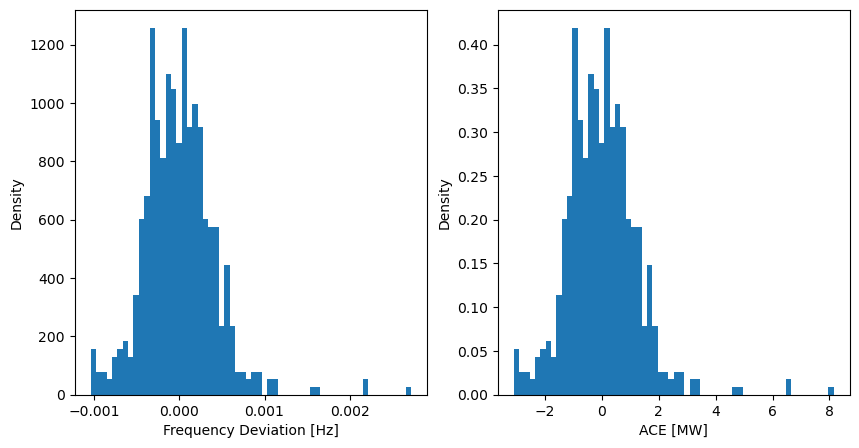

In [19]:
fig_freq, ax_freq = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

outdf_plt.plot(x='time', y='fd', kind='hist', alpha=1, bins=60, density=True,
               ax=ax_freq[0], xlabel='Frequency Deviation [Hz]', ylabel='Density',
               legend=False)
outdf_plt.plot(x='time', y='ACE', kind='hist', alpha=1, bins=60, density=True,
               ax=ax_freq[1], xlabel='ACE [MW]', ylabel='Density',
               legend=False)

## Settings to Improve Performance

Long-term dynamic simulation can be memory-consuming, as time-series data is updated by default. To reduce the memory burden, we can configure the TDS with `save_every=0`, discarding all data immediately after each simulation step. As a trade-off, a separate output array is utilized to store the data, with a resolution matching the co-simulation time step.
More details about ANDES settings can be found in the [ANDES Release notes - v1.7.0](https://docs.andes.app/en/latest/release-notes.html#v1-7-0-2022-05-22).

The case has been tested with a complete 3600s duration. However, for demonstration purposes and to conserve CI resources, the simulated time is truncated.

## Limitations

1. Although the code is designed for generalization, the demo is implemented on the IEEE 39-bus case with generators set to synchronous machines, and its application to other cases is not fully tested.
1. The load curve is synthetic, based on experience.
1. Within each interval, generator setpoints are updated only once, without considering smooth action.
1. In ANDES, certain dynamic parameters are adjusted to facilitate co-simulation, disregarding their actual physical implications.
1. The used case comprises synchronous generators exclusively, necessitating further adaptation for the inclusion of renewable energy sources.

## FAQ

Q: Why ANDES TDS run into error?

A: Most likely, the error is due to power flow not converging. Possible reasons include: 1) load is too heavy, 2) step change is too large, 3) some devices run into limits.

Q: Why in AMS RTED, load and generation do not exactly match?

A: The RTED is converted using ``dc2ac``, where the generation and bus voltage are adjusted using ACOPF.